### VGG 

### Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan K. , ZissermanA. , 2014)
[Paper](https://arxiv.org/abs/1409.1556v6)


*In this work we __investigate the effect of the convolutional network depth on its
accuracy__ in the large-scale image recognition setting. Our __main contribution is
a thorough evaluation of networks of increasing depth using an architecture with
very small (3 × 3) convolution filters__, which shows that a significant improvement
on the prior-art configurations can be achieved by pushing __the depth to 16–19
weight layers__. These findings were the basis of our __ImageNet Challenge 2014__
submission, where our team secured __the first and the second places in the localisation and classification tracks__ respectively.*

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Fbeta, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers.tqdm_logger import ProgressBar

import matplotlib.pyplot as plt

assert torch.cuda.is_available() is True
%load_ext watermark

In [2]:
%watermark -p torch,ignite,numpy

torch : 1.10.2
ignite: 0.4.8
numpy : 1.22.1



#### VGG topology
![VGGTOP](../assets/3_vgg_conf.jpg)
<img src="../assets/5_vgg_params.png" width="400">

#### VGG-16
![VGG16_1](../assets/1_vgg16.jpg)
![VGG16_2](../assets/2_vgg16.jpg)
![VGG16_4](../assets/4_vgg_perf.jpg)

#### Convolutional kernels 1x1 in VGG, type C

* 1x1 without reducing feature maps depth!

*The incorporation of 1 × 1 conv. layers is a __way to increase the non-
linearity of the decision function without affecting the receptive fields of the conv. layers__. Even
though in our case the 1 × 1 convolution is essentially a __linear projection onto the space of the same
dimensionality__ (the number of input and output channels is the same), an __additional non-linearity__ is
introduced by the rectification function.*



<img src="../assets/6_vgg_article_perf.png" width="600">

#### Torch [implementation](https://github.com/pytorch/vision/blob/7d868aa608b94d022c42357ede40bda06af942f4/torchvision/models/vgg.py#L35)

```python
class VGG(nn.Module):
    def __init__(
        self, features: nn.Module, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
```

What's new:

* AdaptiveAvgPool2d with output_size as the only argument instead of MaxPool with kernel_size
* A, B, D, E configurations: 3x3 convolutional kernels
* Optional BatchNorm layers [(Sergey I. Szegedy C., 2015)](https://arxiv.org/abs/1502.03167)

Sequential blocks: feature extractor -> pooling -> classifier

In [3]:
tuple(arch for arch in dir(torchvision.models) if 'vgg'in arch)

('vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn')

In [4]:
vgg11_bn = torchvision.models.vgg11_bn(pretrained=True, progress=False)
vgg11_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

#### CIFAR10 with pytorch ignite

In [5]:
imagenet_norm = {'mean':(0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225)}
val_start = 45000
batch_size = 64
store_data = './data'
device = 'cuda:0'

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(**imagenet_norm)])

trainset = datasets.CIFAR10(store_data, download=True, train=True, transform=transform)
trainset.targets = trainset.targets[:val_start]
trainset.data = trainset.data[:val_start]

valset = datasets.CIFAR10(store_data, download=False, train=True, transform=transform)
valset.targets = valset.targets[val_start:]
valset.data = valset.data[val_start:]

testset = datasets.CIFAR10(store_data, download=True, train=False, transform=transform)


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size)
test_loader = DataLoader(testset, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


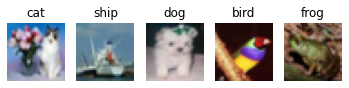

In [6]:
n_imgs = 5
fig, axs = plt.subplots(1, n_imgs)
for i, idx in enumerate(np.random.randint(size=n_imgs, low=0, high=trainset.data.shape[0]-1)):
    axs[i].imshow(trainset.data[idx])
    axs[i].axis('off')
    axs[i].set_title(trainset.classes[trainset.targets[idx]])
plt.show()

In [7]:
(len(trainset.targets), len(valset.targets), len(testset.targets))

(45000, 5000, 10000)

In [8]:
(trainset.data.shape, valset.data.shape, testset.data.shape)

((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
vgg11_bn.classifier[-1] = nn.Linear(in_features=4096, out_features=len(trainset.classes))
vgg11_bn.to('cuda')

optimizer = torch.optim.Adam(vgg11_bn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
vgg11_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [11]:
epochs = 5
trainer = create_supervised_trainer(vgg11_bn, optimizer, criterion, device=device)
metrics = {
    'f1': Fbeta(beta=1),
    'ce':Loss(criterion),
}
train_evaluator = create_supervised_evaluator(vgg11_bn, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(vgg11_bn, metrics=metrics, device=device)

training_history = {'loss':[], 'f1': []}
validation_history = {'loss':[], 'f1': []}
last_epoch = []

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [12]:
print(f'Available events: {dir(Events)[:-4]}')

Available events: ['COMPLETED', 'DATALOADER_STOP_ITERATION', 'EPOCH_COMPLETED', 'EPOCH_STARTED', 'EXCEPTION_RAISED', 'GET_BATCH_COMPLETED', 'GET_BATCH_STARTED', 'ITERATION_COMPLETED', 'ITERATION_STARTED', 'STARTED', 'TERMINATE', 'TERMINATE_SINGLE_EPOCH']


In [13]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    f1 = metrics['f1']
    loss = metrics['ce']
    last_epoch.append(0)
    training_history['f1'].append(f1)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg F1: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, f1, loss))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    f1 = metrics['f1']
    loss = metrics['ce']
    validation_history['f1'].append(f1)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg F1: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, f1, loss))

In [14]:
get_last_val_score = lambda x: validation_history['f1'][-1]
get_last_epoch = lambda eng, last_state: eng.state.epoch
checkpointer = ModelCheckpoint('./saved_models', 'vgg11bn', 
                               global_step_transform=get_last_epoch,
                               score_function=get_last_val_score,
                               create_dir=True, 
                               require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'cifar10': vgg11_bn})

ignite_pbar = ProgressBar()
ignite_pbar.attach(trainer)

In [ ]:
trainer.run(train_loader, max_epochs=epochs)

In [15]:
def fetch_last_checkpoint(model_save_path, name):
    checkpoint_files = (x for x in os.listdir(model_save_path) if name in x)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

vgg11_bn.load_state_dict(torch.load(fetch_last_checkpoint('./saved_models', 'vgg11bn_cifar10')))

<All keys matched successfully>

In [16]:
test_evaluator = create_supervised_evaluator(vgg11_bn, metrics=metrics, device=device)
vgg11_bn.eval()
ProgressBar().attach(test_evaluator)
test_evaluator.run(test_loader)
test_evaluator.state.metrics

[1/157]   1%|           [00:00<?]

{'f1': 0.8320757127350493, 'ce': 0.573735107421875}

#### References

* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf
* https://www.geeksforgeeks.org/vgg-16-cnn-model/
* https://colab.research.google.com/github/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb#scrollTo=Pj7oLY36abx8
* https://pytorch.org/
* https://pytorch.org/ignite/
* https://onnx.ai/
* https://www.cs.toronto.edu/~kriz/cifar.html